<img style="float: left; margin: 30px 15px 15px 15px;" src="https://oci02.img.iteso.mx/Identidades-De-Instancia/ITESO/Logos%20ITESO/Logo-ITESO-Principal.jpg" width="400" height="600" /> 
    
    
## <font color='navy'> Optimización de Programas de Inversión.
    
### <font color='navy'> Anexo #1: Código de Trabajo

**Profesor:** Sean Nicolás González Vázquez.
    
**Elaboración:** 
- Castillo Meda, Lucía.
- Gutiérrez Valdivia, Juan Carlos.
- Orozco Gómez, Daniel.
- Ponce Anguiano, Carlos Daniel.
- Sánches Paszko, José Walden.
    
**Fecha:** 21 Septiembre 2023.

## Preparación del entorno

In [1]:
# Importar librerías 
import os
import time
import requests
import Functions
import numpy as np
import pandas as pd
import seaborn as sns
import yfinance as yf
import matplotlib.pyplot as plt
from datetime import datetime
from valuation import Companies
from sklearn.impute import KNNImputer
#from ydata_profiling import ProfileReport

## Importación de datos y cálculo de fundamentales

In [2]:
# Cargar Datos
income_statement = Functions.load_full_excel('Data/Income/Income_Statement.xlsx')
balance_statement = Functions.load_full_excel('Data/Balance/Balance_Statement.xlsx')
sp500 = Functions.assets(income_statement=income_statement)

# Si se desea cambiar de periodo de analisis cambiar la siguiente fecha:
prices = yf.download(tickers=sp500, start='2018-09-01', end='2023-09-23', progress=False)['Adj Close'] 

In [3]:
# Filtrado de fechas y correcciones temporales
prices_fiscal = Functions.prices_date(balance_statement=balance_statement, prices=prices, sp500=sp500)

# DataFrame limpio con información consolidada de ambos estados financieros y precios
financial_info = Functions.clean_df(balance_statement=balance_statement, 
                                    income_statement=income_statement, 
                                    sp500=sp500, 
                                    prices_fiscal=prices_fiscal)

In [4]:
# Datos en formato tabular
data_table = Functions.tabular_df(financial_info=financial_info, sp500=sp500)

In [5]:
# Cálculo de ratios financieros 
stock = Companies(data_table)
stock.get_ratios()

,Stock,fiscalDateEnding,PER,PBV,Acid_test,ATR,CCC,ROA,DER,NPM,EM
0,A,2023-09-30,294.082262,3.057905,53.781818,0.154379,519.738042,0.010398,0.920655,0.067354,1.920655
1,A,2023-06-30,117.462748,3.287041,inf,0.156505,589.975104,0.027984,0.866805,0.178804,1.866805
2,A,2023-03-31,115.920786,3.736983,12.466387,0.159538,570.189255,0.032237,0.946693,0.202067,1.946693
3,A,2022-12-31,119.540594,4.176884,76.111111,0.174041,496.822863,0.034941,0.985297,0.200764,1.985297
4,A,2022-09-30,108.621838,3.408678,14.888889,0.163201,498.707191,0.031381,1.059320,0.192285,2.059320
...,...,...,...,...,...,...,...,...,...,...,...
15,XRAY,2019-12-31,198.010967,1.780674,4.074675,0.101090,645.963811,0.008993,0.990733,0.088959,1.990733
16,XRAY,2019-09-30,436.233691,1.841033,inf,0.116104,579.950272,0.004220,0.816937,0.036349,1.816937
17,XRAY,2019-06-30,452.607425,1.966550,inf,0.104921,596.190585,0.004345,0.760390,0.041411,1.760390
18,XRAY,2019-03-31,8389.152234,1.686827,inf,0.118376,517.773144,0.000201,0.777601,0.001699,1.777601


## Limpieza de datos

In [6]:
# EDA con miras a limpieza de datos
Functions.dqr(stock.ratios)

,Nombres,Data_Type,Missing_Values,Present_Values,Num_Unique_Values,Min,Max,Categorical,Categories
Stock,Stock,object,0,7760,388,A,XRAY,True,Category too large
fiscalDateEnding,fiscalDateEnding,datetime64[ns],0,7760,20,2018-12-31 00:00:00,2023-09-30 00:00:00,False,Not categorical
PER,PER,float64,37,7723,7707,-123728.496361,inf,False,Not categorical
PBV,PBV,float64,0,7760,7700,0.0,173.594601,False,Not categorical
Acid_test,Acid_test,float64,0,7760,14,3.223702,inf,False,Not categorical
ATR,ATR,float64,0,7760,7616,-0.010471,13.58879,False,Not categorical
CCC,CCC,float64,261,7499,7439,-147204.287791,30649264745.417828,False,Not categorical
ROA,ROA,float64,0,7760,7448,-5.261343,3.839063,False,Not categorical
DER,DER,float64,0,7760,20,0.76039,1.161746,False,Not categorical
NPM,NPM,float64,37,7723,7647,-inf,inf,False,Not categorical


In [7]:
# Conservar solo ratios y reemplazo de infinito (y -infinito) por NaN
ratios_only = stock.ratios.drop(['Stock','fiscalDateEnding'],axis=1).replace(np.inf,np.nan).replace(-np.inf,np.nan)

# Imputación de valores faltantes 
imputer = KNNImputer(n_neighbors=5)
imputed_ratios = imputer.fit_transform(ratios_only)
stock.ratios[['PER','PBV','Acid_test','ATR','CCC','ROA','DER','NPM','EM']] = imputed_ratios
stock.ratios

,Stock,fiscalDateEnding,PER,PBV,Acid_test,ATR,CCC,ROA,DER,NPM,EM
0,A,2023-09-30,294.082262,3.057905,53.781818,0.154379,519.738042,0.010398,0.920655,0.067354,1.920655
1,A,2023-06-30,117.462748,3.287041,26.970165,0.156505,589.975104,0.027984,0.866805,0.178804,1.866805
2,A,2023-03-31,115.920786,3.736983,12.466387,0.159538,570.189255,0.032237,0.946693,0.202067,1.946693
3,A,2022-12-31,119.540594,4.176884,76.111111,0.174041,496.822863,0.034941,0.985297,0.200764,1.985297
4,A,2022-09-30,108.621838,3.408678,14.888889,0.163201,498.707191,0.031381,1.059320,0.192285,2.059320
...,...,...,...,...,...,...,...,...,...,...,...
15,XRAY,2019-12-31,198.010967,1.780674,4.074675,0.101090,645.963811,0.008993,0.990733,0.088959,1.990733
16,XRAY,2019-09-30,436.233691,1.841033,26.970165,0.116104,579.950272,0.004220,0.816937,0.036349,1.816937
17,XRAY,2019-06-30,452.607425,1.966550,26.970165,0.104921,596.190585,0.004345,0.760390,0.041411,1.760390
18,XRAY,2019-03-31,8389.152234,1.686827,26.970165,0.118376,517.773144,0.000201,0.777601,0.001699,1.777601


## Exploratory Data Analysis (EDA)

### Profile Report

In [8]:
# Reporte automatizado utilizando ydata_profiling
#profile = ProfileReport(stock.ratios)
#profile.to_file('Preliminary Report.html')
#profile

### Análisis de correlación

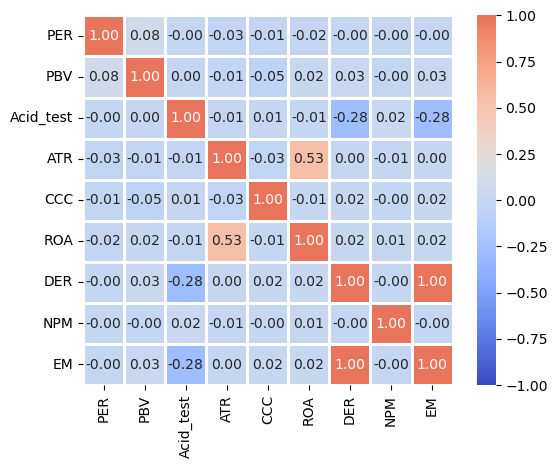

In [9]:
# Mapear correlación completa
sns.heatmap(
    stock.ratios.corr(numeric_only=True), 
    vmin=-1, vmax=1, annot=True, cmap='coolwarm', fmt='.2f', cbar=True, square=True, 
    annot_kws={'size': 10},  linewidth=1, center = 0.2
);

### Histogramas

C:\Users\carlo\anaconda3\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
C:\Users\carlo\anaconda3\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
C:\Users\carlo\anaconda3\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
C:\Users\carlo\anaconda3\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
C:\Users\carlo\anaconda3\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
C:\Users\carlo\anaconda3\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
C:\Users\c

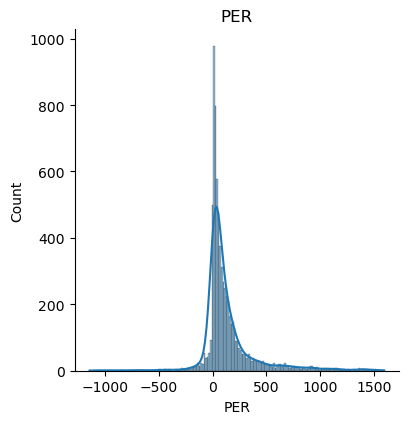

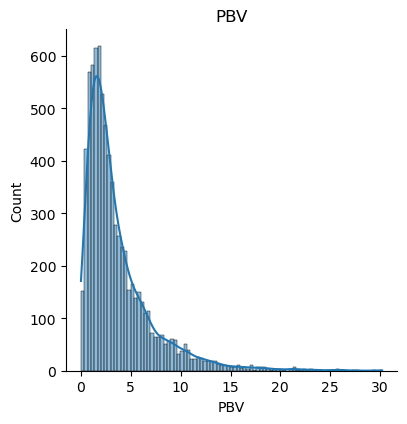

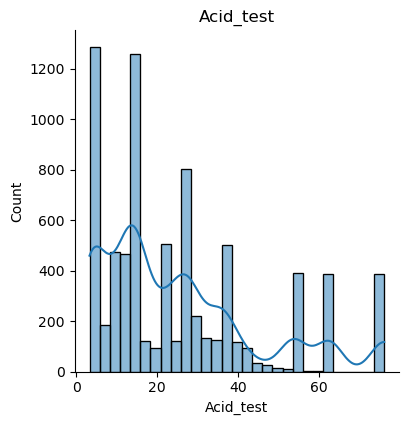

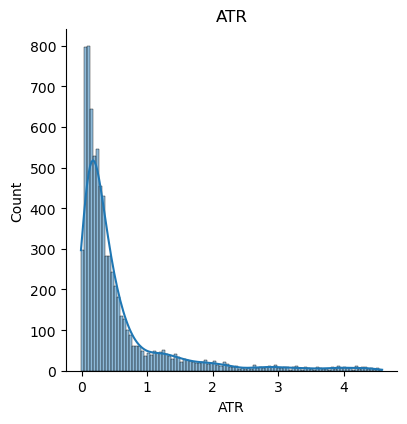

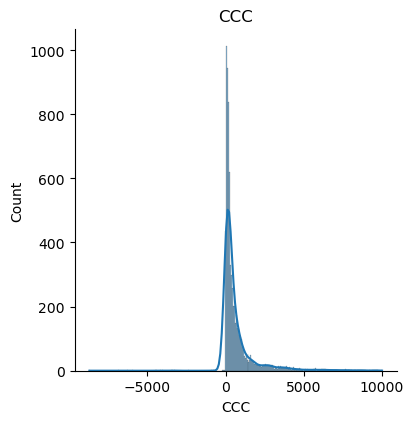

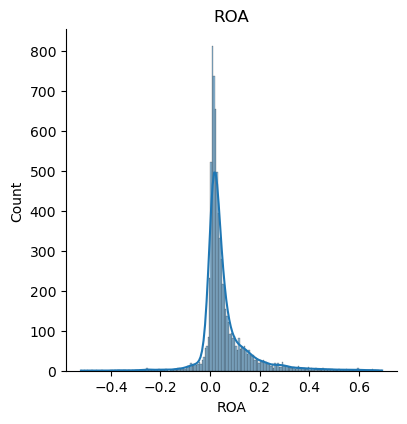

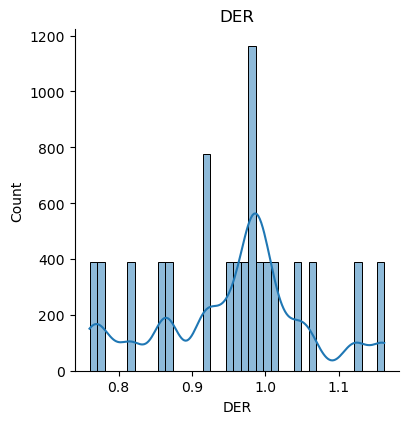

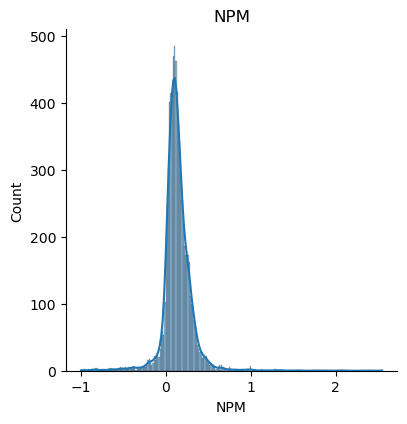

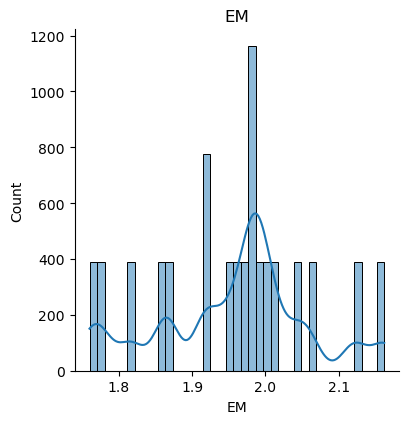

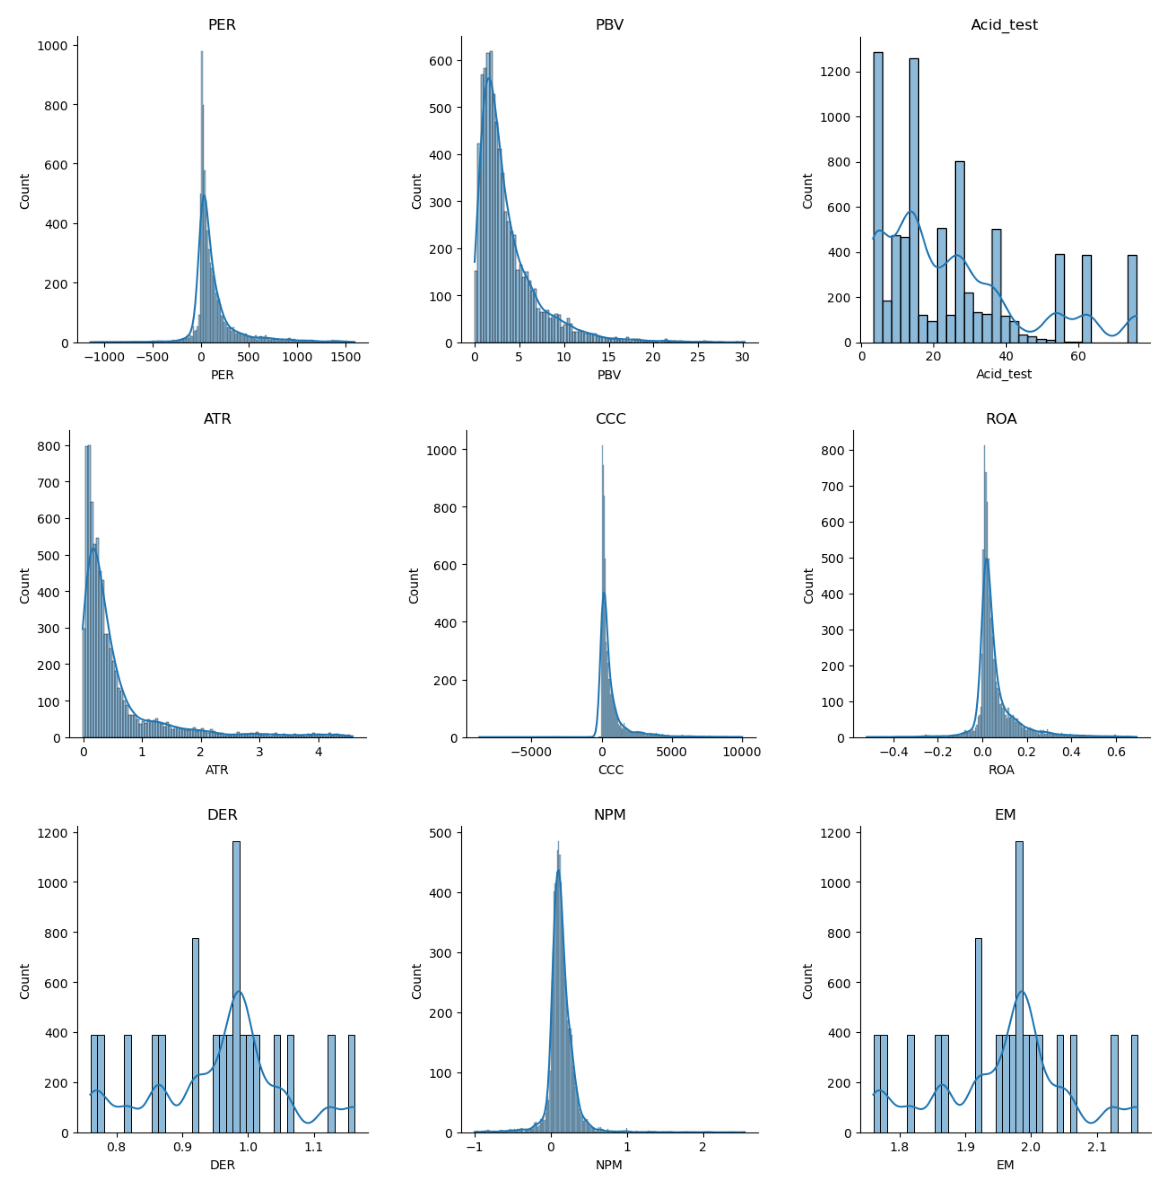

In [10]:
# Conservar solo ratios
ratios_only_full = stock.ratios[['PER','PBV','Acid_test','ATR','CCC','ROA','DER','NPM','EM']]

# Drop de valores atípicos en las distribuciones mediante Z_scores
## PER
z_scores = np.abs((ratios_only_full['PER'] - ratios_only_full['PER'].mean()) / ratios_only_full['PER'].std())
per_no_outliers = ratios_only_full['PER'][z_scores <= .4]
per_num = "{:.2f}%".format((1-(len(ratios_only_full)-len(per_no_outliers))/len(ratios_only_full))*100)

## PBV
z_scores = np.abs((ratios_only_full['PBV'] - ratios_only_full['PBV'].mean()) / ratios_only_full['PBV'].std())
pbv_no_outliers = ratios_only_full['PBV'][z_scores <= 3]
pbv_num = "{:.2f}%".format((1-(len(ratios_only_full)-len(pbv_no_outliers))/len(ratios_only_full))*100)

## Acid test
z_scores = np.abs((ratios_only_full['Acid_test'] - ratios_only_full['Acid_test'].mean()) / ratios_only_full['Acid_test'].std())
at_no_outliers = ratios_only_full['Acid_test']
at_num = "{:.2f}%".format((1-(len(ratios_only_full)-len(at_no_outliers))/len(ratios_only_full))*100)

## ATR
z_scores = np.abs((ratios_only_full['ATR'] - ratios_only_full['ATR'].mean()) / ratios_only_full['ATR'].std())
atr_no_outliers = ratios_only_full['ATR'][z_scores <= 3]
atr_num = "{:.2f}%".format((1-(len(ratios_only_full)-len(atr_no_outliers))/len(ratios_only_full))*100)

## CCC
z_scores = np.abs((ratios_only_full['CCC'] - ratios_only_full['CCC'].mean()) / ratios_only_full['CCC'].std())
ccc_no_outliers = ratios_only_full['CCC']
ccc_no_outliers = ccc_no_outliers[ccc_no_outliers <= 10000]
ccc_no_outliers = ccc_no_outliers[ccc_no_outliers >= -10000]
ccc_num = "{:.2f}%".format((1-(len(ratios_only_full)-len(ccc_no_outliers))/len(ratios_only_full))*100)

## ROA
z_scores = np.abs((ratios_only_full['ROA'] - ratios_only_full['ROA'].mean()) / ratios_only_full['ROA'].std())
roa_no_outliers = ratios_only_full['ROA'][z_scores <= 2.4]
roa_num = "{:.2f}%".format((1-(len(ratios_only_full)-len(roa_no_outliers))/len(ratios_only_full))*100)

## DER
z_scores = np.abs((ratios_only_full['DER'] - ratios_only_full['DER'].mean()) / ratios_only_full['DER'].std())
der_no_outliers = ratios_only_full['DER']
der_num = "{:.2f}%".format((1-(len(ratios_only_full)-len(der_no_outliers))/len(ratios_only_full))*100)

## NPM
z_scores = np.abs((ratios_only_full['NPM'] - ratios_only_full['NPM'].mean()) / ratios_only_full['NPM'].std())
npm_no_outliers = ratios_only_full['NPM'][z_scores <= .035]
npm_num = "{:.2f}%".format((1-(len(ratios_only_full)-len(npm_no_outliers))/len(ratios_only_full))*100)

## EM
z_scores = np.abs((ratios_only_full['EM'] - ratios_only_full['EM'].mean()) / ratios_only_full['EM'].std())
em_no_outliers = ratios_only_full['EM']
em_num = "{:.2f}%".format((1-(len(ratios_only_full)-len(em_no_outliers))/len(ratios_only_full))*100)

# Concentrado de nuevos valores
ratios = ['PER', 'PBV', 'Acid_test', 'ATR', 'CCC', 'ROA', 'DER', 'NPM', 'EM']
ratios_num = [per_num,pbv_num,at_num,atr_num,ccc_num,roa_num,der_num,npm_num,em_num]

# Gráficos
plots = [sns.displot(x=data, kde=True) for data in 
         [per_no_outliers, pbv_no_outliers,  at_no_outliers, atr_no_outliers, ccc_no_outliers, 
          roa_no_outliers, der_no_outliers,npm_no_outliers, em_no_outliers]]
fig, axes = plt.subplots(3, 3, figsize=(12, 12))
axes = axes.flatten()
for i, plot in enumerate(plots):
    plot.fig.set_size_inches(4, 4)                 
    plot.ax.set_title(ratios[i])                 
    plot.savefig("temp.png")                 
    temp_img = plt.imread("temp.png")                 
    axes[i].imshow(temp_img)                 
    axes[i].axis("off")                 
plt.tight_layout()
plt.show()

In [11]:
# Cálculo de valores removidos
removed_vals = {'StringColumn': ratios, '% de datos en la gráfica': ratios_num}
removed_vals = pd.DataFrame(removed_vals)
removed_vals

,StringColumn,% de datos en la gráfica
0,PER,96.61%
1,PBV,98.90%
2,Acid_test,100.00%
3,ATR,97.35%
4,CCC,94.48%
5,ROA,97.54%
6,DER,100.00%
7,NPM,98.89%
8,EM,100.00%
